# Vector and Tensor space models For Natural Language

In this work we investigate word vector and word tensor representations for downstream ML models. We investigate word embeddings that are able to capture similarity and other relationships between words in a document. We lay the ground work for computational genomic analysis 

## Vectors

In [14]:
import pandas as pd
import numpy as np
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec    #Import gensim Word2Fec
from sklearn.decomposition import PCA #Grab PCA functions
from tsne import _bh_sne #Import the t-SNE algorithm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

%matplotlib notebook

[nltk_data] Downloading package reuters to
[nltk_data]     /home/mashjunior/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [15]:
data = []
for fileid in reuters.fileids():
    category = reuters.categories(fileid)
    text = reuters.raw(fileid)
    data.append([fileid, category, text])
df_reuters = pd.DataFrame(data, columns=['File ID', 'Category', 'Text'])

In [16]:
df_reuters.head(10)

,File ID,Category,Text
0,test/14826,[trade],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...
1,test/14828,[grain],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...
2,test/14829,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
3,test/14832,"[corn, grain, rice, rubber, sugar, tin, trade]",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n ...
4,test/14833,"[palm-oil, veg-oil]",INDONESIA SEES CPO PRICE RISING SHARPLY\n Ind...
5,test/14839,[ship],AUSTRALIAN FOREIGN SHIP BAN ENDS BUT NSW PORTS...
6,test/14840,"[coffee, lumber, palm-oil, rubber, veg-oil]",INDONESIAN COMMODITY EXCHANGE MAY EXPAND\n Th...
7,test/14841,"[grain, wheat]",SRI LANKA GETS USDA APPROVAL FOR WHEAT PRICE\n...
8,test/14842,[gold],WESTERN MINING TO OPEN NEW GOLD MINE IN AUSTRA...
9,test/14843,[acq],SUMITOMO BANK AIMS AT QUICK RECOVERY FROM MERG...


In [17]:
len(df_reuters)

10788

There are a total of 10,788 articles.

To our convinience, the articles are already labeled with their respective categories. This helps us in a case we want to perform further analysis and run supervised learning. But we won't be running any supervised learning in this post. But instead, we will extract only the articles that are in the category of crude. In the other words, only the articles that talk about crude oil.

In [18]:
df_crude = df_reuters[df_reuters['Category'].apply(lambda x: 'crude' in x)]
df_crude.head(10)

,File ID,Category,Text
2,test/14829,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
123,test/15063,"[acq, crude, earn, pet-chem]",ENERGY/U.S. PETROCHEMICAL INDUSTRY\n Cheap oi...
187,test/15200,[crude],TURKEY CALLS FOR DIALOGUE TO SOLVE DISPUTE\n ...
205,test/15230,[crude],IRAQI TROOPS REPORTED PUSHING BACK IRANIANS\n ...
209,test/15238,"[crude, earn]",UNION TEXAS OIL RESERVES DROPPED IN 1986\n Un...
214,test/15244,[crude],GHANA TO BUY CRUDE OIL FROM IRAN\n Ghana will...
257,test/15322,"[crude, nat-gas]",U.S.SENATE LIFTS SOME BANS ON NATURAL GAS\n T...
266,test/15339,"[crude, gas]","EIA SAYS DISTILLATE STOCKS UNCHANGED, GASOLINE..."
268,test/15344,"[crude, gas]",EIA SAYS DISTILLATE STOCKS UNCHANGED IN WEEK\n...
272,test/15351,"[crude, gas]",RECENT U.S. OIL DEMAND OFF 2.6 PCT FROM YEAR A...


In [19]:
df_crude.shape

(578, 3)

### Constructing Co-Occurence Matrix 

**Tokenization**

In [20]:
def read_corpus(category=''):
    files = reuters.fileids(category)
    return [['START'] + [w.lower() for w in list(reuters.words(f))] + ['END'] for f in files]

In [21]:
corpus_crude = read_corpus(category=['crude'])

In [22]:
pd.DataFrame(corpus_crude).head(10)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,START,japan,to,revise,long,-,term,energy,demand,downwards,...,None,None,None,None,None,None,None,None,None,None
1,START,energy,/,u,.,s,.,petrochemical,industry,cheap,...,.,economy,continues,its,modest,rate,of,growth,.,END
2,START,turkey,calls,for,dialogue,to,solve,dispute,turkey,said,...,None,None,None,None,None,None,None,None,None,None
3,START,iraqi,troops,reported,pushing,back,iranians,iraq,said,today,...,None,None,None,None,None,None,None,None,None,None
4,START,union,texas,oil,reserves,dropped,in,1986,union,texas,...,None,None,None,None,None,None,None,None,None,None
5,START,ghana,to,buy,crude,oil,from,iran,ghana,will,...,None,None,None,None,None,None,None,None,None,None
6,START,u,.,s,.,senate,lifts,some,bans,on,...,None,None,None,None,None,None,None,None,None,None
7,START,eia,says,distillate,stocks,unchanged,",",gasoline,off,200,...,None,None,None,None,None,None,None,None,None,None
8,START,eia,says,distillate,stocks,unchanged,in,week,distillate,fuel,...,None,None,None,None,None,None,None,None,None,None
9,START,recent,u,.,s,.,oil,demand,off,2,...,None,None,None,None,None,None,None,None,None,None


**Matrix Construction**

In [23]:
def compute_co_occurrence_matrix(corpus, window_size=4):

    distinct_words = sorted(list(set([word for sentence in corpus for word in sentence])))
    num_words = len(distinct_words)
    word2Ind = {word: index for index, word in enumerate(distinct_words)}
    
    M = np.zeros((num_words, num_words))
    
    for sentence in corpus:
        for i, word in enumerate(sentence):        
            begin = max(i - window_size, 0)
            end   = min(i + window_size, num_words)
            context = sentence[begin: end + 1]
            context.remove(sentence[i])
            
            current_row = word2Ind[word]
            for token in context:
                current_col = word2Ind[token]
                M[current_row, current_col] += 1

    return M, word2Ind

In [24]:
reuters_corpus = read_corpus('crude')
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus, window_size=5)

In [25]:
pd.DataFrame(M_co_occurrence, index=word2Ind_co_occurrence.keys(), columns=word2Ind_co_occurrence.keys()).head(10)

,"""","""(",""",","""...",$,&,',(,),")""",...,zinc,zoete,zollinger,zone,zones,zubedei,zubeidi,zuheir,zulia,zverev
"""",88.0,0.0,1.0,0.0,1.0,2.0,78.0,17.0,7.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"""(",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
""",",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&,2.0,0.0,0.0,0.0,0.0,12.0,31.0,8.0,4.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
',78.0,0.0,0.0,0.0,0.0,31.0,22.0,8.0,5.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
(,17.0,0.0,0.0,0.0,0.0,8.0,8.0,6.0,220.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
),7.0,1.0,0.0,0.0,0.0,4.0,5.0,220.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
")""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Factorization via SVD

In [26]:
def reduce_to_k_dim(M, n_components=2):
    
    svd = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)
    M_reduced = svd.fit_transform(M_co_occurrence)  
    
    print('n_components =', n_components)
    print('Explained Variance =', round(svd.explained_variance_ratio_.sum(), 3))
    
    return M_reduced

In [27]:
M_reduced_2 = reduce_to_k_dim(M_co_occurrence, n_components=2)
M_reduced_3 = reduce_to_k_dim(M_co_occurrence, n_components=3)

n_components = 2
Explained Variance = 0.906
n_components = 3
Explained Variance = 0.923


In [28]:
pd.DataFrame(M_reduced_2, columns=['$k_{1}$', '$k_{2}$']).head(10)

,$k_{1}$,$k_{2}$
0,861.598711,-92.837976
1,1.523025,-0.235919
2,0.299002,0.054687
3,0.895219,-0.383224
4,1.626508,-0.125964
5,158.617460,-26.523809
6,975.388537,250.237303
7,211.345647,30.294191
8,162.468186,-12.582009
9,1.272724,-0.197958


## Word Vectors Visualization

The original word vector had 8185-dimension, but now its reduced down to 2-dimension and 3-dimension, which can be visualized on a 2D and 3D plane

**Normalization**

Rescaling (normalization) needs to be done on rows to make each of them unit-length. Skipping this step will result in your visualization looking unbalanced.

In [29]:
# normalize

M_lengths_2 = np.linalg.norm(M_reduced_2, axis=1)
M_normalized_2 = M_reduced_2 / M_lengths_2[:, np.newaxis]

M_lengths_3 = np.linalg.norm(M_reduced_3, axis=1)
M_normalized_3 = M_reduced_3 / M_lengths_3[:, np.newaxis]

**Visualization**

In [30]:
def plot_embeddings(M_reduced, word2Ind, words, ax):
    
    dimension = M_reduced.shape[1]
    
    assert(dimension == 3 or dimension == 2)
    
    for i, word in enumerate(words):
        index = word2Ind[word]
        embedding = M_reduced[index]
        
        if dimension == 3:            
            x, y, z = embedding[0], embedding[1], embedding[2]
            ax.scatter(x, y, z, color='red')
            ax.text(x, y, z, word)
        else:
            x, y = embedding[0], embedding[1]
            ax.scatter(x, y, marker='x', color='red')
            ax.text(x, y,  word)   
    return fig, ax

In [31]:
# choose words to visualize 

words = ['bank', 'barrels', 'bpd', 'ecuador', 'energy', 'industry', 'oil', 'petroleum', 'output', 'produce', 'occidental',
         'mobil', 'exxon', 'electricity' ,'kilowatt', 'china', 'paris', 'saudi', 'norway', 'blockading', 'expert', 'yen', 
         'kuwaiti', 'kuwait', 'persian', 'eia',  'gulf', 'bp', 'uk', 'gas', 'europe', 'allocated', 'lacks', 'militarily', 
         'discouraged', 'violations', 'possibly']

<IPython.core.display.Javascript object>


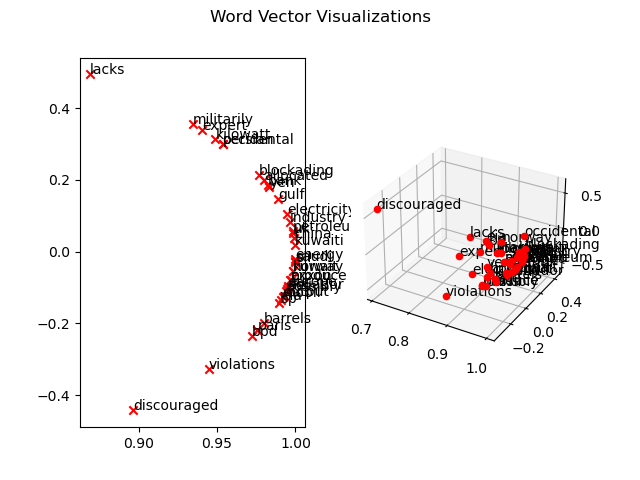

In [32]:
fig = plt.figure(10)
fig.suptitle('Word Vector Visualizations')

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1 = plot_embeddings(M_normalized_2, word2Ind_co_occurrence, words, ax1)


# Second subplot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2 = plot_embeddings(M_normalized_3, word2Ind_co_occurrence, words, ax2)

# Word2vec Mikolov. et al(2013)

In [33]:
# Train a Word2Vec model
reuters_corpus = read_corpus('crude')
model = Word2Vec(reuters_corpus, min_count=1)
# summarize the loaded model
print(model)

# summarise vocabulary
words = list(model.wv.vocab)
print(words[0:10])

Word2Vec(vocab=8185, size=15, alpha=0.025)
['START', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards']


In [34]:
# access vector for one word for reference
print(model['revise'])

[-0.05174065 -0.03047116 -0.03509125  0.01523998  0.01216744  0.01367703
 -0.01987799  0.01310744 -0.04453471 -0.01491769 -0.01580814 -0.01040723
  0.02267993 -0.01721344  0.01610935]


/home/mashjunior/anaconda3/envs/james_genomics/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### Visualizing with PCA

In [35]:
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

/home/mashjunior/anaconda3/envs/james_genomics/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


<IPython.core.display.Javascript object>


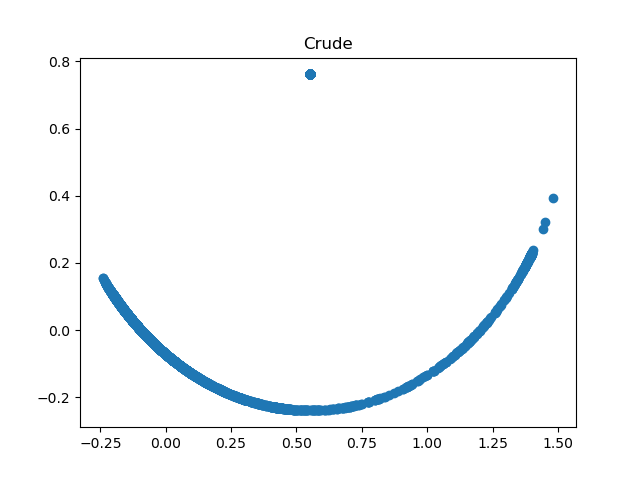

In [73]:
# create a plot of the projection
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Crude')
plt.show()

### Visualizing with t-SNE

In [37]:
#t-SNE

import tsne

tsne.__version__

'0.3.1'

In [38]:
from tsne import bh_sne  # noqa

In [39]:
X.astype('float64')

array([[-1.57563913e+00, -3.26511383e+00, -2.73927927e-01, ...,
        -9.11309958e-01,  3.36173892e-01,  3.22965205e-01],
       [-6.30789101e-01, -1.13290656e+00,  1.39226615e-01, ...,
        -5.80642641e-01,  3.03529412e-01, -2.97708839e-01],
       [-1.41125059e+00, -1.64318573e+00,  9.08421397e-01, ...,
        -1.86902857e+00,  1.19462955e+00, -7.19572961e-01],
       ...,
       [ 6.97643030e-04, -2.96635777e-02, -2.03821883e-02, ...,
        -1.29003264e-02, -2.57418789e-02,  2.23407242e-02],
       [-3.34374718e-02,  1.81973055e-02,  3.83063629e-02, ...,
        -2.13821279e-03,  3.15221399e-02, -5.45866508e-03],
       [-8.94587114e-03, -2.57356055e-02,  2.54316675e-03, ...,
        -1.40596712e-02,  3.51178050e-02, -1.23021919e-02]])

In [40]:
Y = bh_sne(X.astype('float64'), 2, 50, 30.0)

In [41]:
#Plot the t-SNE output

#fig, ax = plt.subplots()
#ax.plot(Y[:, 0], Y[:, 1], 'o')
#ax.set_title('Crude related words')
#ax.set_yticklabels([]) #Hide ticks
#ax.set_xticklabels([]) #Hide ticks
#plt.show()

# **Word Embeddings via PMI Matrix Factorization (Omar Levy and Yoav Goldberg, NIPS 2014)**

From the experiments performed by https://gist.github.com/emaadmanzoor/1d06e0751a3f7d39bc6814941b37531d

In [42]:
from collections import Counter
from itertools import combinations
from math import log
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pformat
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, norm
from string import punctuation

In [43]:
df_crude = df_reuters[df_reuters['Category'].apply(lambda x: 'crude' in x)]
df_crude.head(10)

,File ID,Category,Text
2,test/14829,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
123,test/15063,"[acq, crude, earn, pet-chem]",ENERGY/U.S. PETROCHEMICAL INDUSTRY\n Cheap oi...
187,test/15200,[crude],TURKEY CALLS FOR DIALOGUE TO SOLVE DISPUTE\n ...
205,test/15230,[crude],IRAQI TROOPS REPORTED PUSHING BACK IRANIANS\n ...
209,test/15238,"[crude, earn]",UNION TEXAS OIL RESERVES DROPPED IN 1986\n Un...
214,test/15244,[crude],GHANA TO BUY CRUDE OIL FROM IRAN\n Ghana will...
257,test/15322,"[crude, nat-gas]",U.S.SENATE LIFTS SOME BANS ON NATURAL GAS\n T...
266,test/15339,"[crude, gas]","EIA SAYS DISTILLATE STOCKS UNCHANGED, GASOLINE..."
268,test/15344,"[crude, gas]",EIA SAYS DISTILLATE STOCKS UNCHANGED IN WEEK\n...
272,test/15351,"[crude, gas]",RECENT U.S. OIL DEMAND OFF 2.6 PCT FROM YEAR A...


## 1. Read and preprocess

In [44]:
%%time
punctrans = str.maketrans(dict.fromkeys(punctuation))
def tokenize(Text):
    x = Text.lower() # Lowercase
    x = x.encode('ascii', 'ignore').decode() # Keep only ascii chars.
    x = x.translate(punctrans) # Remove punctuation
    return x.split() # Return tokenized.

texts_tokenized = df_crude['Text'].apply(tokenize)

CPU times: user 27.5 ms, sys: 0 ns, total: 27.5 ms
Wall time: 27.2 ms


## 2a. Compute unigram and bigram counts

A unigram is a single word (x). A bigram is a pair of words (x,y). Bigrams are counted for any two terms occurring in the same title. For example, the title "Foo bar baz" has unigrams [foo, bar, baz] and bigrams [(bar, foo), (bar, baz), (baz, foo)]

In [45]:
%%time
cx = Counter()
cxy = Counter()
for text in texts_tokenized:
    for x in text:
        cx[x] += 1
    for x, y in map(sorted, combinations(text, 2)):
        cxy[(x, y)] += 1

CPU times: user 32.4 s, sys: 159 ms, total: 32.5 s
Wall time: 32.5 s


## 2b. Remove frequent and infrequent unigrams.

Pick arbitrary occurrence count thresholds to eliminate unigrams occurring very frequently or infrequently. This decreases the vocab size substantially.

In [46]:
%%time
print('%d tokens before' % len(cx))
min_count = (1 / 1000) * len(df_crude)
max_count = (1 / 50) * len(df_crude)
for x in list(cx.keys()):
    if cx[x] < min_count or cx[x] > max_count:
        del cx[x]
print('%d tokens after' % len(cx))
print('Most common:', cx.most_common()[:50])

9365 tokens before
8097 tokens after
Most common: [('yen', 11), ('businesses', 11), ('theres', 11), ('helped', 11), ('eastern', 11), ('acquire', 11), ('spent', 11), ('eventually', 11), ('nato', 11), ('iranians', 11), ('killed', 11), ('account', 11), ('42', 11), ('irna', 11), ('bill', 11), ('spr', 11), ('135', 11), ('reach', 11), ('actions', 11), ('singapore', 11), ('ocean', 11), ('secure', 11), ('believed', 11), ('unless', 11), ('run', 11), ('bankruptcy', 11), ('ltrd', 11), ('published', 11), ('dhabi', 11), ('remarks', 11), ('receive', 11), ('worth', 11), ('todays', 11), ('mercantile', 11), ('tokyo', 11), ('javier', 11), ('border', 11), ('side', 11), ('maintained', 11), ('weve', 11), ('198687', 11), ('moving', 11), ('volumes', 11), ('liftings', 11), ('norske', 11), ('named', 11), ('spring', 11), ('hughes', 11), ('twothirds', 11), ('local', 11)]
CPU times: user 7.79 ms, sys: 0 ns, total: 7.79 ms
Wall time: 7.7 ms


## 2c. Remove frequent and infrequent bigrams.

Any bigram containing a unigram that was removed must now be removed.

In [47]:
%%time
for x, y in list(cxy.keys()):
    if x not in cx or y not in cx:
        del cxy[(x, y)]

CPU times: user 3.81 s, sys: 0 ns, total: 3.81 s
Wall time: 3.81 s


## 3. Build unigram <-> index lookup.

In [48]:
%%time
x2i, i2x = {}, {}
for i, x in enumerate(cx.keys()):
    x2i[x] = i
    i2x[i] = x

CPU times: user 2.97 ms, sys: 0 ns, total: 2.97 ms
Wall time: 2.98 ms


## 4. Sum unigram and bigram counts for computing probabilities.

In [49]:
sx = sum(cx.values())
sxy = sum(cxy.values())

## 5. Accumulate data, rows, and cols to build sparse PMI matrix

The PMI value for a bigram with tokens (x, y) is: $$PMI(x,y) =log\frac{P(x,y)}{P(x)P(y)}$$ The probabilities are computed on the fly using the sums from above.

In [50]:
%%time
pmi_samples = Counter()
data, rows, cols = [], [], []
for (x, y), n in cxy.items():
    rows.append(x2i[x])
    cols.append(x2i[y])
    data.append(log((n / sxy) / (cx[x] / sx) / (cx[y] / sx)))
    pmi_samples[(x, y)] = data[-1]
PMI = csc_matrix((data, (rows, cols)))
print('%d non-zero elements' % PMI.count_nonzero())
print('Sample PMI values\n', pformat(pmi_samples.most_common()[:50]))

459150 non-zero elements
Sample PMI values
 [(('kilolitres', 'revise'), 6.511313395470279),
 (('kl', 'revise'), 6.511313395470279),
 (('emergence', 'revise'), 6.511313395470279),
 (('deliberations', 'revise'), 6.511313395470279),
 (('kilowatthour', 'revise'), 6.511313395470279),
 (('kilolitres', 'kl'), 6.511313395470279),
 (('emergence', 'kilolitres'), 6.511313395470279),
 (('deliberations', 'kilolitres'), 6.511313395470279),
 (('kilolitres', 'kilowatthour'), 6.511313395470279),
 (('emergence', 'kl'), 6.511313395470279),
 (('deliberations', 'kl'), 6.511313395470279),
 (('kilowatthour', 'kl'), 6.511313395470279),
 (('deliberations', 'emergence'), 6.511313395470279),
 (('emergence', 'kilowatthour'), 6.511313395470279),
 (('deliberations', 'kilowatthour'), 6.511313395470279),
 (('propel', 'weakened'), 6.511313395470279),
 (('shed', 'weakened'), 6.511313395470279),
 (('gaf', 'weakened'), 6.511313395470279),
 (('ltgaf', 'weakened'), 6.511313395470279),
 (('cain', 'weakened'), 6.511313395470

## 6. Factorize the PMI matrix using sparse SVD aka "learn the unigram/word vectors". 

This part replaces the stochastic gradient descent used by Word2vec and other related neural network formulations. We pick an arbitrary vector size k=20.

In [51]:
%%time
U, _, _ = svds(PMI, k=2)

CPU times: user 394 ms, sys: 8.23 ms, total: 402 ms
Wall time: 54.7 ms


Normalize the vectors to compute cosine similarity.

In [52]:
norms = np.sqrt(np.sum(np.square(U), axis=1, keepdims=True))
U /= np.maximum(norms, 1e-7)

In [53]:
U.shape

(8097, 2)

In [54]:
pca = PCA(n_components=2)
result = pca.fit_transform(U)

<IPython.core.display.Javascript object>


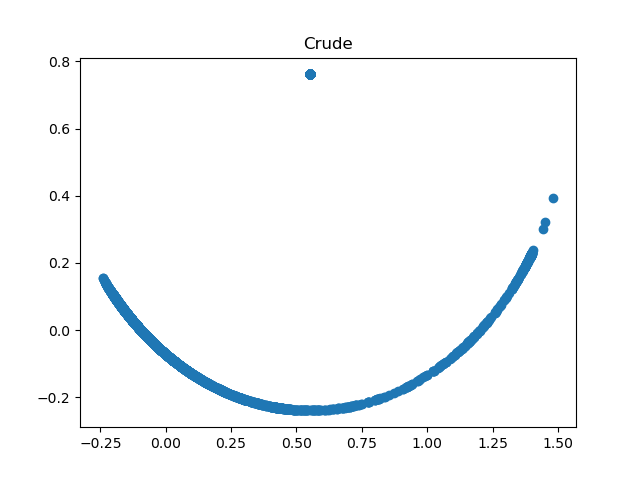

In [55]:
# create a plot of the projection
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Crude')
plt.show()

In [56]:
Y = bh_sne(U.astype('float64'), 2, 50, 30.0)

<IPython.core.display.Javascript object>


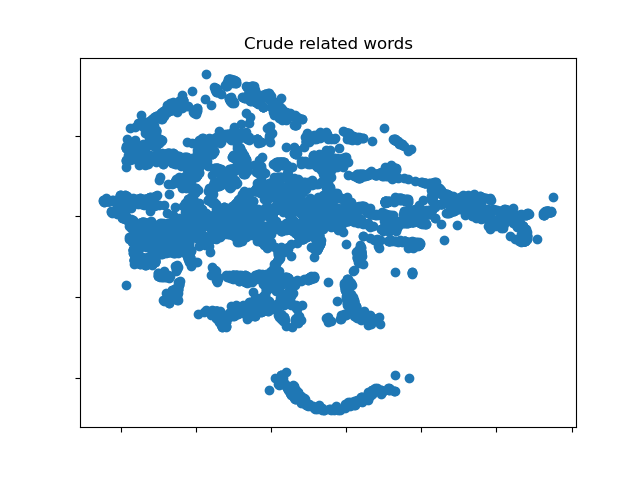

In [57]:
#Plot the t-SNE output

fig, ax = plt.subplots()
ax.plot(Y[:, 0], Y[:, 1], 'o')
ax.set_title('Crude related words')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
plt.show()

# **Tensor Factorization(Still working on this...)**

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

from utils import *

### **Implementation of Tensor Decomposition (using the libraries)**

In [59]:
# Specify the tensor and the rank
X, rank = M_co_occurrence, 3

In [60]:
observed = np.load("/home/mashjunior/Desktop/FactorEmbeddings/embedding_eperiments/tensor-decomposition-in-python/data/observed.npy")

In [61]:
X = X[:-185,:-185]

In [62]:
X.shape

(8000, 8000)

In [63]:
X = np.reshape(X, (len(X), X.ndim, -1)) 

In [64]:
X.ndim

3

In [65]:
observed.ndim

3

In [66]:
# Perform CP decompositon using TensorLy
#factors_tl = parafac(X, rank=rank)

In [67]:
# Perform CP decomposition using tensortools
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

In [68]:
factors_tt

[array([[-3.55365780e-01,  1.28828835e+00, -1.29008217e+00],
        [-2.73767262e-03,  1.05445856e-03, -3.27111042e-03],
        [ 5.99451881e-04,  3.35467719e-04, -6.30841913e-04],
        ...,
        [ 1.59528898e-03,  3.26452373e-03, -1.82579506e-03],
        [ 9.67832463e-03,  1.28500792e-02, -1.29304427e-02],
        [-2.33503258e-04,  2.52242815e-03, -7.70957406e-04]]),
 array([[14.28840591, 22.10397178,  0.25648861],
        [-0.32149983,  1.89732227, 20.82315394]]),
 array([[ 2.39377482e-01,  1.66028992e+00,  1.54511401e-01],
        [ 2.74487459e-03,  2.26002864e-03, -1.85841595e-03],
        [ 6.35829453e-06,  5.22844808e-04, -1.02542389e-03],
        ...,
        [-6.66038851e-04,  2.33376192e-03, -3.42914937e-03],
        [-9.15498679e-04,  3.41666426e-03, -1.72024797e-02],
        [-3.02038665e-03,  4.29327776e-03, -2.35890817e-03]])]

<IPython.core.display.Javascript object>


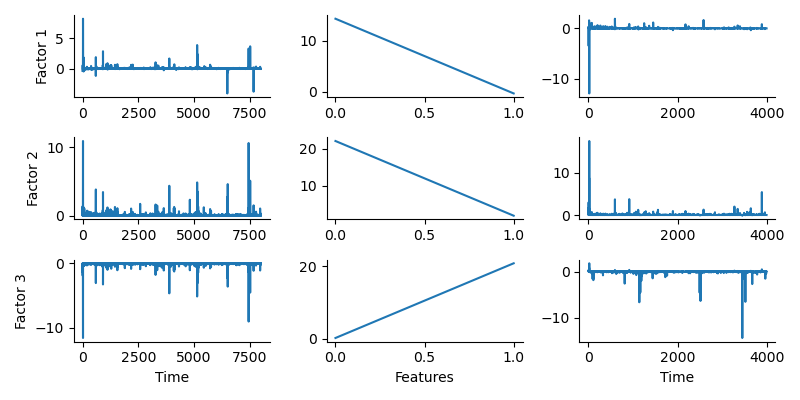

In [74]:
# Reconstruct M, with the result of each library
#M_tl = reconstruct(factors_tl)
M_tt = reconstruct(factors_tt)

# plot the decomposed factors
#plot_factors(factors_tl)
plot_factors(factors_tt)

# Apply vector and tensor embeddings to Genomics data

In [70]:
#import os
#if not os.path.exists('ActinoMock_Nanopore.seq.gz'):
#    !wget http://ww2.cs.fsu.edu/~lshi/ActinoMock_Nanopore.seq.gz

In [71]:
4**5

1024